<a href="https://colab.research.google.com/github/BashayerAB/Arabic_OCR/blob/main/TinyVGGusingAHCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/levalencia/DataScience-Portfolio/blob/main/SimpsonsClassifier/Pytorch%20-%20Simpsons%20Multi%20Classifier.ipynb

In [1]:
import torch
import requests
import zipfile
import os
import shutil
import random
import pathlib
import pandas as pd
import numpy as np
import torchvision

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from pathlib import Path
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# Lets check Pytorch version
torch.__version__

'2.1.0+cu118'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bashayerbinsiddiq","key":"12346bef7d07f8dc1d7b6ed2f80a0ef3"}'}

In [5]:
#creat a kaggle folder
! mkdir ~/.kaggle

In [6]:
#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [7]:
# premission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d mloey1/ahcd1

 96% 23.0M/24.0M [00:00<00:00, 79.7MB/s]
100% 24.0M/24.0M [00:00<00:00, 72.4MB/s]


In [9]:
!unzip ahcd1.zip


Streaming output truncated to the last 5000 lines.
  inflating: train images 13440x32x32/train/id_5500_label_16.png  
  inflating: train images 13440x32x32/train/id_5501_label_16.png  
  inflating: train images 13440x32x32/train/id_5502_label_16.png  
  inflating: train images 13440x32x32/train/id_5503_label_16.png  
  inflating: train images 13440x32x32/train/id_5504_label_16.png  
  inflating: train images 13440x32x32/train/id_5505_label_17.png  
  inflating: train images 13440x32x32/train/id_5506_label_17.png  
  inflating: train images 13440x32x32/train/id_5507_label_17.png  
  inflating: train images 13440x32x32/train/id_5508_label_17.png  
  inflating: train images 13440x32x32/train/id_5509_label_17.png  
  inflating: train images 13440x32x32/train/id_550_label_13.png  
  inflating: train images 13440x32x32/train/id_5510_label_17.png  
  inflating: train images 13440x32x32/train/id_5511_label_17.png  
  inflating: train images 13440x32x32/train/id_5512_label_17.png  
  inflating:

In [10]:
train_image = pd.read_csv("/content/arabic handwritten characters dataset csv/csvTrainImages 13440x1024.csv", header = None)
train_label = pd.read_csv("/content/arabic handwritten characters dataset csv/csvTrainLabel 13440x1.csv", header = None)
test_image = pd.read_csv("/content/arabic handwritten characters dataset csv/csvTestImages 3360x1024.csv", header = None )
test_label = pd.read_csv("/content/arabic handwritten characters dataset csv/csvTestLabel 3360x1.csv", header = None )

In [11]:
# add the lables of the dataset
train_image['label'] = train_label
test_image['label'] = test_label

print(train_image.shape)

(13440, 1025)


In [12]:
from IPython.core.display import Image
from PIL import Image
class GrayscaleToRGB(object):
    def __call__(self, img):
        return img.convert('RGB')
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image_array = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(32,32)
        image = Image.fromarray(image_array)
        label = self.data.iloc[index, -1] - 1

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [13]:
# uint8 	 Unsigned integer (0 to 255)
transform = transforms.Compose([
    GrayscaleToRGB(), ## this is added in the new code
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    transforms.Resize(size=(64,64)), ## this is added in the new code
    #transforms.
    ])
train_image_dataset = ImageDataset(train_image, transform)
test_image_dataset = ImageDataset(test_image, transform)

In [14]:
image , label = train_image_dataset.__getitem__(32)

image.size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 64, 64])

In [15]:
# Setup path for target directory
train_target_directory = "/content/Train Images 13440x32x32/train"
print(f"Target dir: {train_target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(train_target_directory))])
class_names_found

Target dir: /content/Train Images 13440x32x32/train


['id_10000_label_18.png',
 'id_10001_label_19.png',
 'id_10002_label_19.png',
 'id_10003_label_19.png',
 'id_10004_label_19.png',
 'id_10005_label_19.png',
 'id_10006_label_19.png',
 'id_10007_label_19.png',
 'id_10008_label_19.png',
 'id_10009_label_20.png',
 'id_1000_label_13.png',
 'id_10010_label_20.png',
 'id_10011_label_20.png',
 'id_10012_label_20.png',
 'id_10013_label_20.png',
 'id_10014_label_20.png',
 'id_10015_label_20.png',
 'id_10016_label_20.png',
 'id_10017_label_21.png',
 'id_10018_label_21.png',
 'id_10019_label_21.png',
 'id_1001_label_14.png',
 'id_10020_label_21.png',
 'id_10021_label_21.png',
 'id_10022_label_21.png',
 'id_10023_label_21.png',
 'id_10024_label_21.png',
 'id_10025_label_22.png',
 'id_10026_label_22.png',
 'id_10027_label_22.png',
 'id_10028_label_22.png',
 'id_10029_label_22.png',
 'id_1002_label_14.png',
 'id_10030_label_22.png',
 'id_10031_label_22.png',
 'id_10032_label_22.png',
 'id_10033_label_23.png',
 'id_10034_label_23.png',
 'id_10035_labe

In [16]:
# Setup path for target directory
test_target_directory = "/content/Test Images 3360x32x32/test"
print(f"Target dir: {test_target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(test_target_directory))])
class_names_found

Target dir: /content/Test Images 3360x32x32/test


['id_1000_label_24.png',
 'id_1001_label_25.png',
 'id_1002_label_25.png',
 'id_1003_label_26.png',
 'id_1004_label_26.png',
 'id_1005_label_27.png',
 'id_1006_label_27.png',
 'id_1007_label_28.png',
 'id_1008_label_28.png',
 'id_1009_label_1.png',
 'id_100_label_22.png',
 'id_1010_label_1.png',
 'id_1011_label_2.png',
 'id_1012_label_2.png',
 'id_1013_label_3.png',
 'id_1014_label_3.png',
 'id_1015_label_4.png',
 'id_1016_label_4.png',
 'id_1017_label_5.png',
 'id_1018_label_5.png',
 'id_1019_label_6.png',
 'id_101_label_23.png',
 'id_1020_label_6.png',
 'id_1021_label_7.png',
 'id_1022_label_7.png',
 'id_1023_label_8.png',
 'id_1024_label_8.png',
 'id_1025_label_9.png',
 'id_1026_label_9.png',
 'id_1027_label_10.png',
 'id_1028_label_10.png',
 'id_1029_label_11.png',
 'id_102_label_23.png',
 'id_1030_label_11.png',
 'id_1031_label_12.png',
 'id_1032_label_12.png',
 'id_1033_label_13.png',
 'id_1034_label_13.png',
 'id_1035_label_14.png',
 'id_1036_label_14.png',
 'id_1037_label_15.pn

In [17]:
data_path = Path("data/")
combined_dataset_dir = data_path / "combined_dataset"
os.makedirs(combined_dataset_dir, exist_ok=True)

In [18]:
import shutil

# Move the training dataset
train_dataset_dir = "/content/Train Images 13440x32x32/train"
for root, dirs, files in os.walk(train_dataset_dir):
    for file in files:
        src = os.path.join(root, file)
        dst = os.path.join(combined_dataset_dir, file)
        shutil.move(src, dst)

# Move the testing dataset
test_dataset_dir = "/content/Test Images 3360x32x32/test"
for root, dirs, files in os.walk(test_dataset_dir):
    for file in files:
        src = os.path.join(root, file)
        dst = os.path.join(combined_dataset_dir, file)
        shutil.move(src, dst)

combined_dataset_dir

PosixPath('data/combined_dataset')

In [19]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(combined_dataset_dir)

There are 0 directories and 16680 images in 'data/combined_dataset'.


In [21]:
image_path = os.path.join(data_path, "orgnized_data")

In [24]:
import os
import shutil

dataset_dir = "/content/data/combined_dataset"
output_dir = "/content/data/orgnized_data"
train_ratio = 0.8  # Ratio of images to be placed in the training set

# Create the training and testing folders in the output directory
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of image files in the AHCD dataset
image_files = [file for file in os.listdir(dataset_dir) if file.endswith(".png")]

# Shuffle the image files randomly
random.shuffle(image_files)

# Split the image files into training and testing sets based on the given ratio
train_count = int(train_ratio * len(image_files))
train_files = image_files[:train_count]
test_files = image_files[train_count:]

# Iterate over the training files
for file in train_files:
    # Extract the index of the letter from the image's name
    index = int(file.split("_")[3].split(".")[0])

    # Create the folder based on the extracted index if it doesn't exist
    class_dir = os.path.join(train_dir, str(index))
    os.makedirs(class_dir, exist_ok=True)

    # Move the image file to the corresponding class folder
    src = os.path.join(dataset_dir, file)
    dst = os.path.join(class_dir, file)
    shutil.copy(src, dst)

# Iterate over the testing files
for file in test_files:
    # Extract the index of the letter from the image's name
    index = int(file.split("_")[3].split(".")[0])

    # Create the folder based on the extracted index if it doesn't exist
    class_dir = os.path.join(test_dir, str(index))
    os.makedirs(class_dir, exist_ok=True)

    # Move the image file to the corresponding class folder
    src = os.path.join(dataset_dir, file)
    dst = os.path.join(class_dir, file)
    shutil.copy(src, dst)

the snipped of code to delete a folder from the Files section


In [23]:
import shutil

# Specify the path of the folder to be deleted
folder_path = '/content/data/orgnized_data'

# Delete the folder
shutil.rmtree(folder_path)

In [25]:
import os
image_path_organised = "/content/data/orgnized_data"

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path_organised)

There are 2 directories and 0 images in '/content/data/orgnized_data'.
There are 28 directories and 0 images in '/content/data/orgnized_data/test'.
There are 0 directories and 114 images in '/content/data/orgnized_data/test/19'.
There are 0 directories and 124 images in '/content/data/orgnized_data/test/14'.
There are 0 directories and 122 images in '/content/data/orgnized_data/test/20'.
There are 0 directories and 121 images in '/content/data/orgnized_data/test/6'.
There are 0 directories and 123 images in '/content/data/orgnized_data/test/21'.
There are 0 directories and 106 images in '/content/data/orgnized_data/test/17'.
There are 0 directories and 121 images in '/content/data/orgnized_data/test/16'.
There are 0 directories and 119 images in '/content/data/orgnized_data/test/28'.
There are 0 directories and 128 images in '/content/data/orgnized_data/test/23'.
There are 0 directories and 111 images in '/content/data/orgnized_data/test/1'.
There are 0 directories and 110 images in '/

In [28]:
import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(28)

# 1. Get all image paths
image_path_organised = "/content/data/orgnized_data"
image_path_list = list(Path(image_path_organised).rglob("*/*/*.png"))

# Print the number of image paths found
print(f"Number of image paths: {len(image_path_list)}")

# 2. Pick a random image path
if image_path_list:
    random_image_path = random.choice(image_path_list)
    print(random_image_path)

    # 3. Get image class from path name
    image_class = random_image_path.parent.stem
    print(image_class)

    # 4. Open image
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
else:
    print("No image paths found.")

Number of image paths: 16680
/content/data/orgnized_data/train/19/id_6648_label_19.png
19
Random image path: /content/data/orgnized_data/train/19/id_6648_label_19.png


/content/data/orgnized_data/train/19/id_6648_label_19.png
19
Random image path:/content/data/orgnized_data/train/19/id_6648_label_19.png
Image class: 19
Image height: 32
Image width: 32


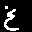

In [30]:
import random
from PIL import Image

# Set seed
random.seed(28)

# 1. Get all image paths
image_path_list = list(Path(image_path_organised).glob("*/*/*.png"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path:{random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 31.5, 31.5, -0.5)

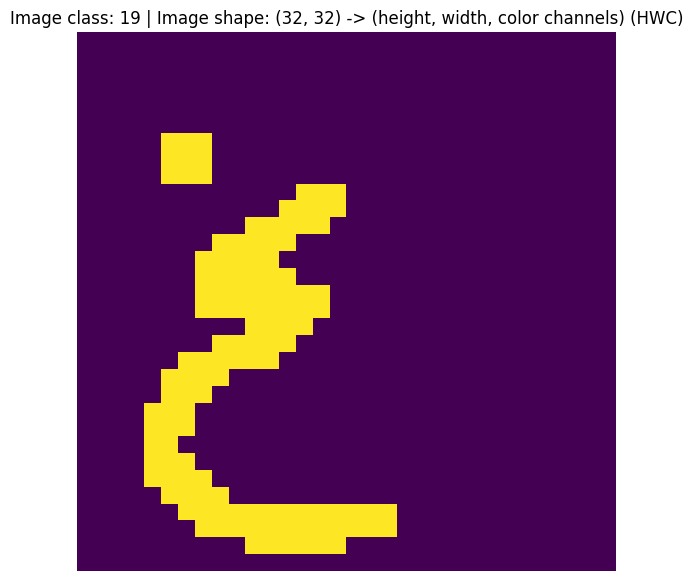

In [31]:
# Try to visualize and image with matplotlib.

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (height, width, color channels) (HWC)")
plt.axis(False)

In [32]:
data_transform = transforms.Compose([
    GrayscaleToRGB(), ## this is added in the new code
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    transforms.Resize(size=(64,64)), ## this is added in the new code
    #transforms.
    ])


In [33]:
# Now we can transform our random image and print out the dtype, shape and the img representation (tensor)
data_transform(img).dtype,data_transform(img).shape, data_transform(img)

(torch.float32,
 torch.Size([3, 64, 64]),
 tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]))

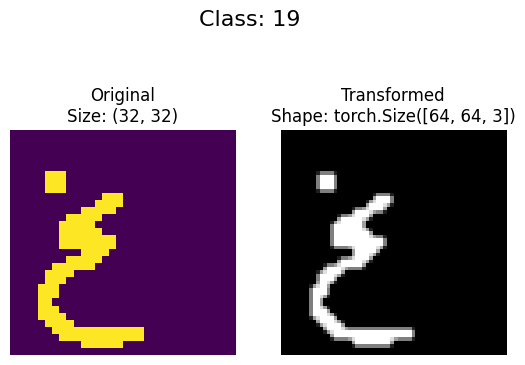

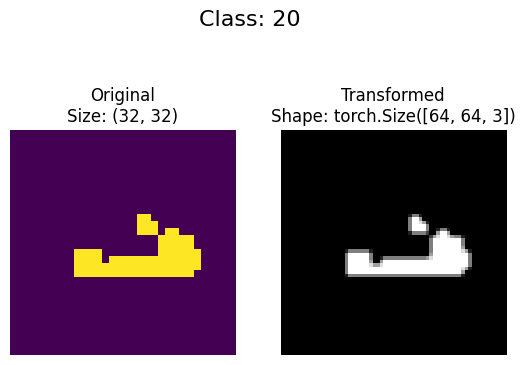

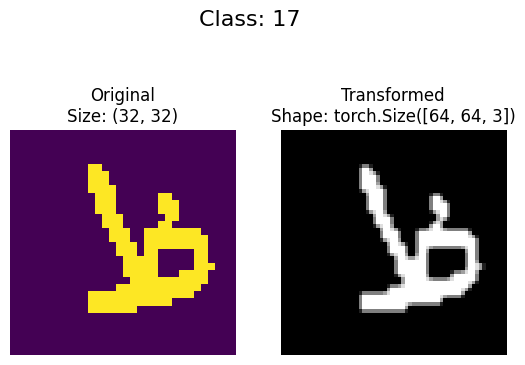

In [45]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=28)

In [35]:
# Setup train and test paths
train_dir = os.path.join(image_path_organised, "train")
test_dir = os.path.join(image_path_organised, "test")
train_dir, test_dir

('/content/data/orgnized_data/train', '/content/data/orgnized_data/test')

In [36]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: /content/data/orgnized_data/train


['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [37]:
from typing import List, Dict, Tuple
import os
import re

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory and assigns indices based on numerical order"""

    # 1. Get the class names by scanning the target directory
    classes = [entry.name for entry in os.scandir(directory) if entry.is_dir()]

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure")

    # 3. Sort the class names based on numerical order
    classes.sort(key=lambda x: int(re.search(r"\d+", x).group()))

    # 4. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

classes, class_to_idx = find_classes(target_directory)

# Print the classes and their corresponding indices
for class_name, index in class_to_idx.items():
    print(f"Class: {class_name}, Index: {index}")

Class: 1, Index: 0
Class: 2, Index: 1
Class: 3, Index: 2
Class: 4, Index: 3
Class: 5, Index: 4
Class: 6, Index: 5
Class: 7, Index: 6
Class: 8, Index: 7
Class: 9, Index: 8
Class: 10, Index: 9
Class: 11, Index: 10
Class: 12, Index: 11
Class: 13, Index: 12
Class: 14, Index: 13
Class: 15, Index: 14
Class: 16, Index: 15
Class: 17, Index: 16
Class: 18, Index: 17
Class: 19, Index: 18
Class: 20, Index: 19
Class: 21, Index: 20
Class: 22, Index: 21
Class: 23, Index: 22
Class: 24, Index: 23
Class: 25, Index: 24
Class: 26, Index: 25
Class: 27, Index: 26
Class: 28, Index: 27


In [38]:
# 0. Write a custom dataset class


# 1. Subclass torch.utils.data.Dataset
class ArabicHCDataset(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.png"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [39]:
# Test out ArabicHCDataset Custom Dataset
train_data_custom = ArabicHCDataset(targ_dir=train_dir,
                                      transform=data_transform)
test_data_custom = ArabicHCDataset(targ_dir=test_dir,
                                     transform=data_transform)

In [40]:
train_data_custom, test_data_custom

(<__main__.ArabicHCDataset at 0x7d53f4994ca0>,
 <__main__.ArabicHCDataset at 0x7d53f4997c10>)

In [41]:
len(train_data_custom), len(test_data_custom)

(13344, 3336)

In [42]:
train_data_custom.classes, train_data_custom.class_to_idx

(['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28'],
 {'1': 0,
  '2': 1,
  '3': 2,
  '4': 3,
  '5': 4,
  '6': 5,
  '7': 6,
  '8': 7,
  '9': 8,
  '10': 9,
  '11': 10,
  '12': 11,
  '13': 12,
  '14': 13,
  '15': 14,
  '16': 15,
  '17': 16,
  '18': 17,
  '19': 18,
  '20': 19,
  '21': 20,
  '22': 21,
  '23': 22,
  '24': 23,
  '25': 24,
  '26': 25,
  '27': 26,
  '28': 27})

In [43]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

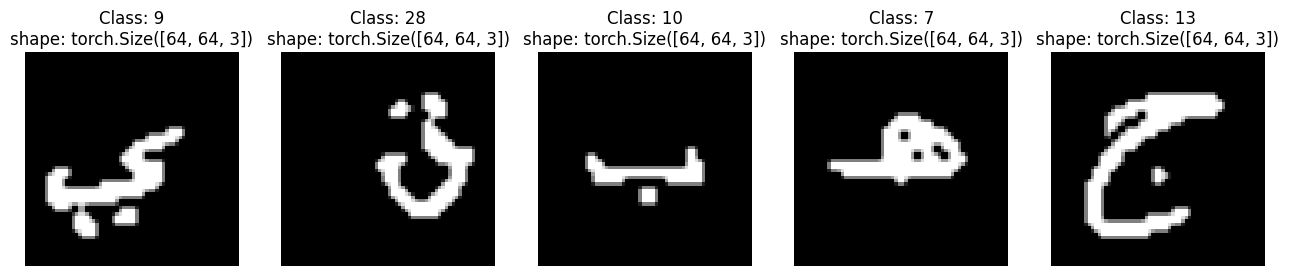

In [44]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names_found,
                      seed=None)

In [46]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d53f4997490>,
 <torch.utils.data.dataloader.DataLoader at 0x7d53f4996bf0>)

In [47]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [55]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       GrayscaleToRGB(),
                                       transforms.ToTensor()
])

In [56]:
# 1. Instantiate ArabicHCDataset custom datasets
train_data_simple = ArabicHCDataset(targ_dir=train_dir,
                                         transform=simple_transform)
test_data_simple = ArabicHCDataset(targ_dir=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(
                          dataset=train_image_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)
test_loader = DataLoader(dataset=test_image_dataset,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_loader , test_loader

In [ ]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_loader))

# Print out the shapes
img_custom.shape, label_custom.shape

In [ ]:
classes_names = np.unique(train_label)
classes_names

In [50]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html


In [51]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names_found)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=28, bias=True)
  )
)

In [57]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [58]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 3.1390e-02,  7.2779e-03,  3.5364e-02, -5.1972e-04,  1.6722e-02,
          1.1437e-02,  1.9801e-02,  7.3667e-02,  5.9546e-03, -6.9609e-02,
         -3.2528e-02,  6.9147e-02, -8.9121e-03, -3.3611e-02,  2.4463e-02,
         -2.2032e-03,  1.0131e-02, -1.4440e-02,  7.3178e-02, -1.6647e-03,
          9.7990e-02, -2.5465e-02,  2.2176e-02,  4.0629e-03, -2.1028e-02,
          1.6459e-02, -2.7458e-03, -1.0131e-02],
        [ 2.9805e-02,  1.0388e-02,  3.6473e-02, -3.5712e-03,  1.5604e-02,
          1.0405e-02,  2.0334e-02,  6.9304e-02,  8.3254e-03, -7.1845e-02,
         -3.6539e-02,  7.1251e-02, -8.5627e-03, -3.5137e-02,  2.4813e-02,
         -4.4793e-05,  1.0725e-02, -1.5803e-02,  7.1070e-02, -4.2137e-04,
          9.3375e-02, -2.4470e-02,  2.3765e-02,  3.2835e-03, -2.2629e-02,
          1.2714e-02, -1.4651e-03, -9.9598e-03],
        [ 3.1198e-02,  8.5087e-03,  3.7569e-02, -2.3061e-03,  1.5468e-02,
          1.2956e-02,  2.1174e-02,  7.0400e-02,  4.0917e-03, -7.1430e-02,
         -3.79

In [59]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 28]                   --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [60]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [61]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [62]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [63]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data_custom.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.2323 | Train acc: 0.3537 | Test loss: 1.4265 | Test acc: 0.5649
Epoch: 1 | Train loss: 1.1156 | Train acc: 0.6738 | Test loss: 0.9576 | Test acc: 0.7065
Epoch: 2 | Train loss: 0.7611 | Train acc: 0.7695 | Test loss: 0.8696 | Test acc: 0.7330
Epoch: 3 | Train loss: 0.6069 | Train acc: 0.8091 | Test loss: 0.8201 | Test acc: 0.7503
Epoch: 4 | Train loss: 0.5144 | Train acc: 0.8377 | Test loss: 0.7803 | Test acc: 0.7610
Epoch: 5 | Train loss: 0.4369 | Train acc: 0.8612 | Test loss: 0.8658 | Test acc: 0.7598
Epoch: 6 | Train loss: 0.3836 | Train acc: 0.8759 | Test loss: 0.8255 | Test acc: 0.7705
Epoch: 7 | Train loss: 0.3277 | Train acc: 0.8937 | Test loss: 0.8526 | Test acc: 0.7690
Epoch: 8 | Train loss: 0.2899 | Train acc: 0.9024 | Test loss: 0.9003 | Test acc: 0.7696
Epoch: 9 | Train loss: 0.2572 | Train acc: 0.9146 | Test loss: 0.9598 | Test acc: 0.7625
Total training time: 98.670 seconds


In [ ]:
# Get the model_0_results keys
model_0_results.keys()

In [64]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

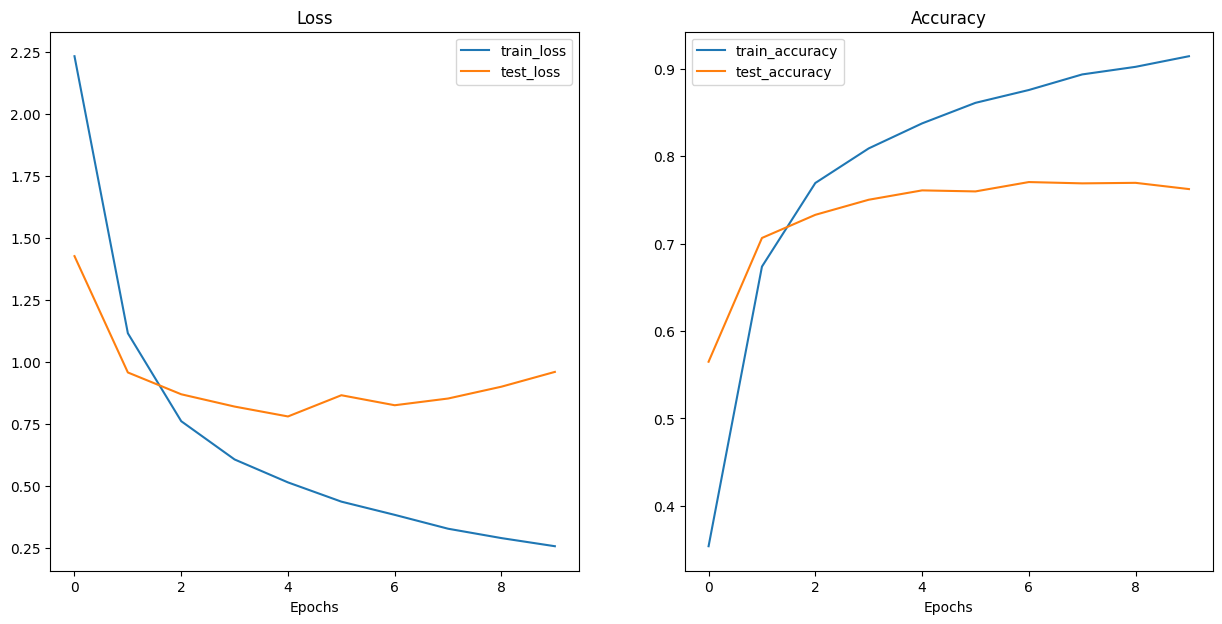

In [65]:
plot_loss_curves(model_0_results)

In [ ]:
# Set random seeds
torch.manual_seed(28)
torch.cuda.manual_seed(28)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(class_names_found)).to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001) ##اغير هنا

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

In [73]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               GrayscaleToRGB(),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            GrayscaleToRGB(),
                                            transforms.ToTensor()
])


In [74]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = ArabicHCDataset(targ_dir=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = ArabicHCDataset(targ_dir=test_dir,
                                        transform=test_transform_simple)

In [75]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [76]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=28, bias=True)
  )
)

In [77]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
#
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 3.3331 | Train acc: 0.0351 | Test loss: 3.3330 | Test acc: 0.0315
Epoch: 1 | Train loss: 3.3323 | Train acc: 0.0351 | Test loss: 3.3334 | Test acc: 0.0307
Epoch: 2 | Train loss: 3.3323 | Train acc: 0.0363 | Test loss: 3.3336 | Test acc: 0.0315
Epoch: 3 | Train loss: 3.3323 | Train acc: 0.0361 | Test loss: 3.3337 | Test acc: 0.0301
Epoch: 4 | Train loss: 3.3323 | Train acc: 0.0361 | Test loss: 3.3338 | Test acc: 0.0301
Epoch: 5 | Train loss: 3.3323 | Train acc: 0.0355 | Test loss: 3.3339 | Test acc: 0.0301
Epoch: 6 | Train loss: 3.3323 | Train acc: 0.0360 | Test loss: 3.3339 | Test acc: 0.0301
Epoch: 7 | Train loss: 3.3323 | Train acc: 0.0348 | Test loss: 3.3340 | Test acc: 0.0301
Epoch: 8 | Train loss: 3.3323 | Train acc: 0.0364 | Test loss: 3.3339 | Test acc: 0.0301
Epoch: 9 | Train loss: 3.3323 | Train acc: 0.0360 | Test loss: 3.3340 | Test acc: 0.0301
Total training time for model_1: 129.279 seconds


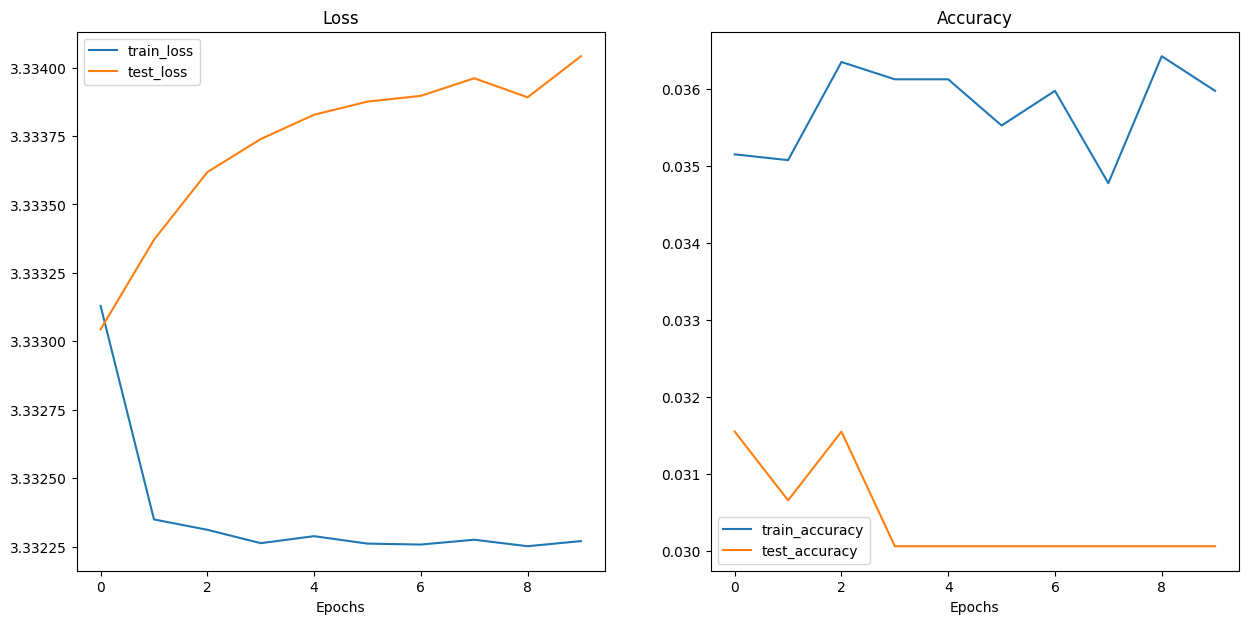

In [78]:
plot_loss_curves(model_1_results)

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary(training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how mnay epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(10, 3))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

In [ ]:
plot_loss_curves(model_0_results)

Epoch: 1 | Train loss: 1.1742 | Train acc: 0.6413 | Test loss: 0.9748 | Test acc: 0.7006

---


Epoch: 2 | Train loss: 0.7871 | Train acc: 0.7568 | Test loss: 0.8146 | Test acc: 0.7515

---


Epoch: 3 | Train loss: 0.6047 | Train acc: 0.8065 | Test loss: 0.7137 | Test acc: 0.7824

---


Epoch: 4 | Train loss: 0.4633 | Train acc: 0.8528 | Test loss: 0.6605 | Test acc: 0.8068

---


Epoch: 5 | Train loss: 0.3719 | Train acc: 0.8803 | Test loss: 0.6782 | Test acc: 0.8086

---


Epoch: 6 | Train loss: 0.3200 | Train acc: 0.8950 | Test loss: 0.6123 | Test acc: 0.8253

---


Epoch: 7 | Train loss: 0.2456 | Train acc: 0.9186 | Test loss: 0.6651 | Test acc: 0.8345

---


Epoch: 8 | Train loss: 0.2071 | Train acc: 0.9295 | Test loss: 0.6998 | Test acc: 0.8315

---


Epoch: 9 | Train loss: 0.1814 | Train acc: 0.9377 | Test loss: 0.6480 | Test acc: 0.8402

---


Total training time: 549.482 seconds >> 9m 9s on **CPU** 10 epoch


Epoch: 1 | Train loss: 0.9970 | Train acc: 0.6895 | Test loss: 0.7995 | Test acc: 0.7592

---


Epoch: 2 | Train loss: 0.6664 | Train acc: 0.7875 | Test loss: 0.7010 | Test acc: 0.7830

---


Epoch: 3 | Train loss: 0.5170 | Train acc: 0.8342 | Test loss: 0.6530 | Test acc: 0.8054

---


Epoch: 4 | Train loss: 0.4081 | Train acc: 0.8715 | Test loss: 0.5938 | Test acc: 0.8208

---


Epoch: 5 | Train loss: 0.3249 | Train acc: 0.8960 | Test loss: 0.6247 | Test acc: 0.8277

---


Epoch: 6 | Train loss: 0.2668 | Train acc: 0.9112 | Test loss: 0.6098 | Test acc: 0.8274

---


Epoch: 7 | Train loss: 0.2184 | Train acc: 0.9249 | Test loss: 0.5868 | Test acc: 0.8509

---


Epoch: 8 | Train loss: 0.1851 | Train acc: 0.9359 | Test loss: 0.6453 | Test acc: 0.8414

---


Epoch: 9 | Train loss: 0.1480 | Train acc: 0.9510 | Test loss: 0.6693 |Test acc: 0.8539

---


Total training time: 228.356 seconds >> 3m 47s on **GPU** 10 epoch

In [ ]:
import os
import shutil

# Paths to the original train and test image folders
train_dir_original = "/content/Train images 13440x32x32/train"
test_dir_original = "/content/Test Images 3360x32x32/test"

# Path to the consolidated data directory
consolidated_data_dir = "/content/consolidated_data"

# Iterate through the train image folder and move images to consolidated folders
for root, dirs, files in os.walk(train_dir_original):
    for file in files:
        # Get the letter from the image filename
        letter = file.split("_")[0]

        # Create the letter folder if it doesn't exist
        letter_folder = os.path.join(consolidated_data_dir, "train", letter)
        os.makedirs(letter_folder, exist_ok=True)

        # Move the image to the letter folder
        src = os.path.join(root, file)
        dst = os.path.join(letter_folder, file)
        shutil.move(src, dst)

# Iterate through the test image folder and move images to consolidated folders
for root, dirs, files in os.walk(test_dir_original):
    for file in files:
        # Get the letter from the image filename
        letter = file.split("_")[0]

        # Create the letter folder if it doesn't exist
        letter_folder = os.path.join(consolidated_data_dir, "test", letter)
        os.makedirs(letter_folder, exist_ok=True)

        # Move the image to the letter folder
        src = os.path.join(root, file)
        dst = os.path.join(letter_folder, file)
        shutil.move(src, dst)

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_dir = "/content/train images 13440x32x32"
train_dir1 = os.path.join(train_dir, "train")

test_dir = "/content/Test Images 3360x32x32"
test_dir1 = os.path.join(test_dir, "test")

train_dir1, test_dir1

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir1, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir1, transform=test_transform)

train_data_augmented, test_data_simple

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

In [ ]:
 ### import some useful helper functions from there!
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper file already exists, abort download!")
else:
  print("downloading helper_functions.py!")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn

In [ ]:

def train_setup(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device = device):
  train_loss, train_acc = 0,0
  model.to(device)
  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc  += accuracy_fn(y,
                        y_pred.argmax(dim=1)) ## to get prediction labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc  /= len(data_loader)
  print(f"train loss: {train_loss:.2f} train accuracy: {train_acc:.3f}%\n")


In [ ]:
## to generate a data dictionary of the evaluated model
def eval_model(
                model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
               device: torch.device=device):
  loss, acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in (data_loader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y,
                         y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return{"model_name" : model.__class__.__name__,
         "model_loss" : loss.item(),
         "model_acc"  : acc}

In [ ]:
eval_model(model_0,
           test_loader,
           loss_fn,
           accuracy_fn)

In [ ]:
## creating a prediction function for any data samples
def make_predictions(model: torch.nn.Module,
                    data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device) ## prepare sample
      pred_logit = model(sample) ## forward pass
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)

      pred_probs.append(pred_prob.cpu()) ## move data sample to cpu

  return torch.stack(pred_probs) ## stack list into tensor

In [ ]:
# note that your labels dataset doesnt define Arabic letters only their indexes
class_names = class_names_found

In [ ]:
test_image_dataset = ImageDataset(test_image, transform)

In [ ]:
### now lets try random samples from original test_data!
import random
test_samples = []
test_labels = []

for sample,label in random.sample(list(test_image_dataset),k=len(test_image_dataset)):
  test_samples.append(sample)
  test_labels.append(label)

print(f"Test sample image shape: {test_samples[1].shape}\nTest sample label: {test_labels[1]} ({class_names[test_labels[1]]})")

In [ ]:
test_samples[1].shape

In [ ]:
prediction_probs = make_predictions(model_0,test_samples) ## to get logits
prediction_Label = prediction_probs.argmax(dim=1) ## to get the labels

In [ ]:
letter_names = {
    0: "أ",
    1: "ب",
    2: "ت",
    3:"ث",
    4:"ج",
    5:"ح",
    6:"خ",
    7:"د",
    8:"ذ",
    9:"ر",
    10:"ز",
    11:"س",
    12:"ش",
    13:"ص",
    14:"ض",
    15:"ط",
    16:"ظ",
    17:"ع",
    18:"غ",
    19:"ف",
    20:"ق",
    21:"ك",
    22:"ل",
    23:"م",
    24:"ن",
    25:"ه",
    26:"و",
    27:"ي",
}

In [ ]:
plt.figure(figsize=(2,2))
inx = 899 ## random index of an image

image_data = test_samples[inx].permute(1, 2, 0)  # Reshape the image data
plt.imshow(image_data, cmap='gray')

predicted_label_indix = test_labels[inx].item()
predicted_letter = letter_names[predicted_label_indix]

true_label_index = test_labels[inx].item()
true_letter = letter_names[true_label_index]

print_labels = f"predicted label: {class_names[prediction_Label[inx]]} -- {predicted_letter}| True label {class_names[test_labels[inx]]} -- {true_letter}"
if (class_names[prediction_Label[inx]] == class_names[test_labels[inx]] ):
    plt.title(print_labels, c = 'g')
else:
    plt.title(print_labels, c = 'r')

In [ ]:
## try it with more samples in a loop
correct_preds = 0
incorrect_preds = 0
for i in range(0, len(test_loader)):
  if (class_names[prediction_Label[i]] == class_names[test_labels[i]] ):
    correct_preds =correct_preds + 1
  else:
    incorrect_preds = incorrect_preds + 1

print(f'Number of correct predictions: {correct_preds}\nNumber of Incorrect predictions: {incorrect_preds} ')

print(f'Percentage of correct predictions: {correct_preds/len(test_loader) *100:.3f} % \nPercentage of Incorrect predictions: {incorrect_preds/len(test_loader)*100:.3f} % ')